In [1]:
!pip -q install boto3 s3fs pyarrow pandas pyspark==3.5.1 sqlalchemy psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os, json, uuid, datetime as dt
import pandas as pd
import numpy as np

# Spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

In [3]:
import os, io, uuid, datetime as dt
import numpy as np, pandas as pd
import boto3

In [4]:
S3_BUCKET = "kartikay77-audio-pipeline"   # <-- your bucket
AWS_REGION = "us-east-2"                   # your region (Ohio)
S3_PREFIX  = "audio_pipeline_demo"         # folder in your bucket

# Paste your keys here (or use Colab secrets)
os.environ["AWS_ACCESS_KEY_ID"]     = "-"
os.environ["AWS_SECRET_ACCESS_KEY"] = "-"
os.environ["AWS_DEFAULT_REGION"]    = AWS_REGION

RAW_PREFIX    = f"s3://{S3_BUCKET}/{S3_PREFIX}/raw"
CURATED_PREFIX= f"s3://{S3_BUCKET}/{S3_PREFIX}/curated"


In [5]:
s3 = boto3.client("s3", region_name=AWS_REGION)
print("Buckets:")
for b in s3.list_buckets()["Buckets"]:
    print(" -", b["Name"])

Buckets:
 - kartikay77-audio-pipeline


In [6]:
rng = np.random.default_rng(42)
today = dt.date.today()

# users
n_users = 500
users = pd.DataFrame({
    "user_id": [f"u_{i:05d}" for i in range(n_users)],
    "country": rng.choice(["US","CA","UK","DE","IN","AU"], size=n_users, p=[.35,.1,.15,.1,.25,.05]),
    "signup_date": pd.to_datetime(rng.integers(0, 365, size=n_users), unit="D",
                                  origin=pd.Timestamp(today - dt.timedelta(days=365)))
})

# titles
n_titles = 200
titles = pd.DataFrame({
    "title_id": [f"t_{i:05d}" for i in range(n_titles)],
    "category": rng.choice(["Fiction","Non-Fiction","Self-Help","Tech","Kids","Wellness"], size=n_titles),
    "duration_secs": rng.integers(1800, 36000, size=n_titles)
})

# sessions
n_sessions = 50_000
dates = pd.to_datetime(rng.integers(0, 60, size=n_sessions), unit="D",
                       origin=pd.Timestamp(today - dt.timedelta(days=60)))
sessions = pd.DataFrame({
    "session_id": [str(uuid.uuid4()) for _ in range(n_sessions)],
    "user_id": rng.choice(users["user_id"], size=n_sessions),
    "title_id": rng.choice(titles["title_id"], size=n_sessions),
    "session_date": dates,
    "seconds_listened": rng.integers(60, 12_000, size=n_sessions),
    "device": rng.choice(["iOS","Android","Web","Echo"], size=n_sessions, p=[.4,.35,.2,.05]),
})
# Add some bad rows to test DQ
bad = rng.choice(n_sessions, 200, replace=False)
sessions.loc[bad, "seconds_listened"] = -1

# helper upload
def df_to_s3_csv(df, key):
    buf = io.StringIO(); df.to_csv(buf, index=False)
    s3.put_object(Bucket=S3_BUCKET, Key=key, Body=buf.getvalue())

df_to_s3_csv(users,  f"{S3_PREFIX}/raw/users/users.csv")
df_to_s3_csv(titles, f"{S3_PREFIX}/raw/titles/titles.csv")
for d, part in sessions.groupby(sessions["session_date"].dt.date):
    df_to_s3_csv(part, f"{S3_PREFIX}/raw/sessions/dt={d}/sessions.csv")

print("Raw users/titles/sessions uploaded to S3")

Raw users/titles/sessions uploaded to S3


In [8]:
# --- Fix Java for Spark in Colab ---
!apt -qq update
!apt -qq install -y openjdk-11-jdk

import os, sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

!java -version

# Reinstall PySpark to ensure a clean match
!pip -q install --upgrade pyspark==3.5.1

45 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk openjdk-11

In [9]:
# Stop any half-started Spark
try:
    spark.stop()
except:
    pass

import os
from pyspark.sql import SparkSession

aws_key = os.environ["AWS_ACCESS_KEY_ID"]
aws_sec = os.environ["AWS_SECRET_ACCESS_KEY"]

# Slightly newer AWS SDK bundle can help avoid jar conflicts
packages = ",".join([
    "org.apache.hadoop:hadoop-aws:3.3.4",
    "com.amazonaws:aws-java-sdk-bundle:1.12.539"
])

spark = (
    SparkSession.builder
    .appName("audio_pipeline_demo")
    .config("spark.jars.packages", packages)
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.hadoop.fs.s3a.aws.credentials.provider",
            "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")
    .config("spark.hadoop.fs.s3a.access.key", aws_key)
    .config("spark.hadoop.fs.s3a.secret.key", aws_sec)
    # Optional stability knobs:
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)

spark

In [10]:
RAW_PREFIX = f"s3a://{S3_BUCKET}/{S3_PREFIX}/raw"
test_df = spark.read.option("header", True).csv(f"{RAW_PREFIX}/users/users.csv")
test_df.show(5)

+-------+-------+-----------+
|user_id|country|signup_date|
+-------+-------+-----------+
|u_00000|     IN| 2025-08-31|
|u_00001|     CA| 2025-08-04|
|u_00002|     IN| 2025-05-31|
|u_00003|     DE| 2025-09-28|
|u_00004|     US| 2024-12-25|
+-------+-------+-----------+
only showing top 5 rows



In [11]:
from pyspark.sql import functions as F

RAW_PREFIX = f"s3a://kartikay77-audio-pipeline/audio_pipeline_demo/raw"
CURATED_PREFIX = f"s3a://kartikay77-audio-pipeline/audio_pipeline_demo/curated"

# read the three raw datasets
raw_users    = spark.read.option("header", True).csv(f"{RAW_PREFIX}/users/users.csv")
raw_titles   = spark.read.option("header", True).csv(f"{RAW_PREFIX}/titles/titles.csv")
raw_sessions = spark.read.option("header", True).csv(f"{RAW_PREFIX}/sessions/*/*.csv")

# convert datatypes and clean negatives
users_s = raw_users.withColumn("signup_date", F.to_date("signup_date"))
titles_s = raw_titles.withColumn("duration_secs", F.col("duration_secs").cast("int"))
sessions_s = (
    raw_sessions
    .withColumn("session_date", F.to_timestamp("session_date"))
    .withColumn("seconds_listened", F.col("seconds_listened").cast("int"))
)

# remove bad sessions (negative durations)
sessions_clean = sessions_s.filter(F.col("seconds_listened") > 0)
print("Cleaned all data successfully!")

Cleaned all data successfully!


In [12]:
fact = (
    sessions_clean
    .join(users_s,  "user_id", "left")
    .join(titles_s, "title_id", "left")
    .withColumn("date", F.to_date("session_date"))
    .withColumn("completed",
                (F.col("seconds_listened") >= F.col("duration_secs") * 0.9).cast("boolean"))
)

dim_users  = users_s.select("user_id", "country", "signup_date").dropDuplicates(["user_id"])
dim_titles = titles_s.select("title_id", "category", "duration_secs").dropDuplicates(["title_id"])
fact_listenings = fact.select(
    "session_id", "user_id", "title_id", "date", "device",
    "seconds_listened", "duration_secs", "completed", "country"
)
print("Joined users, titles, and sessions into curated tables!")

Joined users, titles, and sessions into curated tables!


In [13]:
(fact_listenings.repartition(1)
 .write.mode("overwrite").partitionBy("date")
 .parquet(f"{CURATED_PREFIX}/fact_listenings"))

(dim_users.repartition(1)
 .write.mode("overwrite").parquet(f"{CURATED_PREFIX}/dim_users"))

(dim_titles.repartition(1)
 .write.mode("overwrite").parquet(f"{CURATED_PREFIX}/dim_titles"))

print("Curated Parquet data written to S3 successfully!")

Curated Parquet data written to S3 successfully!


In [14]:
# Average listening duration by device and country
(fact_listenings.groupBy("device", "country")
 .agg(F.avg("seconds_listened").alias("avg_secs"))
 .orderBy(F.desc("avg_secs"))
 .show(10, truncate=False))

# Completion rate by content category
(fact.groupBy("category")
 .agg(F.mean(F.col("completed").cast("int")).alias("completion_rate"))
 .orderBy(F.desc("completion_rate"))
 .show(10, truncate=False))

# Daily active users (DAU) for last 14 days
(fact_listenings.filter(F.col("date") >= F.date_sub(F.current_date(), 14))
 .groupBy("date")
 .agg(F.countDistinct("user_id").alias("DAU"))
 .orderBy("date")
 .show(20, truncate=False))

+-------+-------+------------------+
|device |country|avg_secs          |
+-------+-------+------------------+
|Echo   |UK     |6276.185483870968 |
|Web    |CA     |6193.53050672182  |
|Echo   |DE     |6168.415094339623 |
|Android|DE     |6156.40752189593  |
|Echo   |AU     |6143.238095238095 |
|Echo   |US     |6125.7460510328065|
|iOS    |UK     |6116.800788954635 |
|iOS    |DE     |6110.888789638231 |
|Android|US     |6110.197310152534 |
|Android|UK     |6091.074377091856 |
+-------+-------+------------------+
only showing top 10 rows

+-----------+-------------------+
|category   |completion_rate    |
+-----------+-------------------+
|Non-Fiction|0.20114802149487054|
|Tech       |0.1866056096164854 |
|Wellness   |0.17871840094062316|
|Fiction    |0.1558219178082192 |
|Kids       |0.14409970141503312|
|Self-Help  |0.0                |
+-----------+-------------------+

+----------+---+
|date      |DAU|
+----------+---+
|2025-10-26|403|
|2025-10-27|413|
|2025-10-28|397|
|2025-10-29|3

In [15]:
resp = s3.list_objects_v2(Bucket="kartikay77-audio-pipeline", Prefix="audio_pipeline_demo/curated/")
for item in resp.get("Contents", []):
    print(item["Key"])

audio_pipeline_demo/curated/dim_titles/_SUCCESS
audio_pipeline_demo/curated/dim_titles/part-00000-1b966a8a-ee57-4ef2-8b1b-7edb33f71fd3-c000.snappy.parquet
audio_pipeline_demo/curated/dim_users/_SUCCESS
audio_pipeline_demo/curated/dim_users/part-00000-f3d80158-41cb-4206-9457-f4f1cc7e6d77-c000.snappy.parquet
audio_pipeline_demo/curated/fact_listenings/_SUCCESS
audio_pipeline_demo/curated/fact_listenings/date=2025-09-10/part-00000-bba2081a-d0da-4530-b2ca-cc615b323dfe.c000.snappy.parquet
audio_pipeline_demo/curated/fact_listenings/date=2025-09-11/part-00000-bba2081a-d0da-4530-b2ca-cc615b323dfe.c000.snappy.parquet
audio_pipeline_demo/curated/fact_listenings/date=2025-09-12/part-00000-bba2081a-d0da-4530-b2ca-cc615b323dfe.c000.snappy.parquet
audio_pipeline_demo/curated/fact_listenings/date=2025-09-13/part-00000-bba2081a-d0da-4530-b2ca-cc615b323dfe.c000.snappy.parquet
audio_pipeline_demo/curated/fact_listenings/date=2025-09-14/part-00000-bba2081a-d0da-4530-b2ca-cc615b323dfe.c000.snappy.parquet

In [16]:
from pyspark.sql import functions as F


dq_counts = {
    "sessions_nulls": sessions_s.select([
        F.sum(F.col(c).isNull().cast("int")).alias(f"{c}_nulls") for c in sessions_s.columns
    ]).collect()[0].asDict(),
    "users_nulls": users_s.select([
        F.sum(F.col(c).isNull().cast("int")).alias(f"{c}_nulls") for c in users_s.columns
    ]).collect()[0].asDict(),
    "titles_nulls": titles_s.select([
        F.sum(F.col(c).isNull().cast("int")).alias(f"{c}_nulls") for c in titles_s.columns
    ]).collect()[0].asDict(),
}

neg_count = sessions_s.filter(F.col("seconds_listened") <= 0).count()
if neg_count > 0:
    print(f"[DQ] Found {neg_count} invalid sessions with non-positive seconds_listened")

user_keys   = users_s.select("user_id").distinct()
title_keys  = titles_s.select("title_id").distinct()

orphan_user_sessions  = sessions_s.join(user_keys,  "user_id",  "left_anti").count()
orphan_title_sessions = sessions_s.join(title_keys, "title_id", "left_anti").count()

print(f"[DQ] Orphan sessions (no user match): {orphan_user_sessions}")
print(f"[DQ] Orphan sessions (no title match): {orphan_title_sessions}")

users_s  = users_s.dropDuplicates(["user_id"])
titles_s = titles_s.dropDuplicates(["title_id"])

sessions_clean = sessions_s.filter(F.col("seconds_listened") > 0)

[DQ] Found 200 invalid sessions with non-positive seconds_listened
[DQ] Orphan sessions (no user match): 0
[DQ] Orphan sessions (no title match): 0


In [18]:
# 1) Who am I calling as?
import boto3, re
sts = boto3.client("sts")
who = sts.get_caller_identity()
print("Caller ARN:", who["Arn"])
print("Caller Account:", who["Account"])

# 2) Paste the role ARN you used for the crawler:
iam_role = "arn:aws:iam::<ACCOUNT_ID>:role/<GlueCrawlerRole>"
m = re.match(r"arn:aws:iam::(\d+):role/.+", iam_role)
print("Role Account:", m.group(1) if m else "bad ARN")

Caller ARN: arn:aws:iam::723827337419:root
Caller Account: 723827337419
Role Account: bad ARN


In [20]:
import boto3
region     = "us-east-2"
bucket     = "kartikay77-audio-pipeline"
prefix     = "audio_pipeline_demo/curated/"
db_name    = "audio"
crawler    = "audio_curated_crawler"
iam_role   = "arn:aws:iam::723827337419:role/AWSGlueServiceRole-audio"

glue = boto3.client("glue", region_name=region)

# Create DB if missing
try:
    glue.create_database(DatabaseInput={"Name": db_name})
except glue.exceptions.AlreadyExistsException:
    pass

# Create or update crawler
try:
    glue.create_crawler(
        Name=crawler,
        Role=iam_role,
        DatabaseName=db_name,
        Targets={"S3Targets": [{"Path": f"s3://{bucket}/{prefix}"}]},
        TablePrefix="audio_",
        SchemaChangePolicy={
            "UpdateBehavior": "UPDATE_IN_DATABASE",
            "DeleteBehavior": "DEPRECATE_IN_DATABASE"
        }
    )
except glue.exceptions.AlreadyExistsException:
    glue.update_crawler(
        Name=crawler,
        Role=iam_role,
        DatabaseName=db_name,
        Targets={"S3Targets": [{"Path": f"s3://{bucket}/{prefix}"}]},
        TablePrefix="audio_",
    )

glue.start_crawler(Name=crawler)
print("Started Glue crawler.")

Started Glue crawler.


In [22]:
import time

while True:
    status = glue.get_crawler(Name=crawler)["Crawler"]["State"]
    print("Crawler status:", status)
    if status == "READY":
        print("Crawler finished successfully.")
        break
    time.sleep(10)

Crawler status: READY
Crawler finished successfully.


In [23]:
tables = glue.get_tables(DatabaseName=db_name)["TableList"]
for t in tables:
    print("-", t["Name"])

- audio_dim_titles
- audio_dim_users
- audio_fact_listenings


In [24]:
athena = boto3.client("athena", region_name=region)

query = """
SELECT category, COUNT(*) AS num_titles, ROUND(AVG(duration_secs), 2) AS avg_duration
FROM audio.audio_dim_titles
GROUP BY category
ORDER BY num_titles DESC
LIMIT 10;
"""

output = f"s3://{bucket}/athena-results/"

response = athena.start_query_execution(
    QueryString=query,
    QueryExecutionContext={"Database": db_name},
    ResultConfiguration={"OutputLocation": output},
)

print("Query started with ID:", response["QueryExecutionId"])

Query started with ID: d899c5f0-96f1-4e5f-bd4c-7734a5745b16


In [25]:
qid = response["QueryExecutionId"]

while True:
    state = athena.get_query_execution(QueryExecutionId=qid)["QueryExecution"]["Status"]["State"]
    if state in ["SUCCEEDED", "FAILED", "CANCELLED"]:
        print("Athena query state:", state)
        break
    time.sleep(3)

if state == "SUCCEEDED":
    results = athena.get_query_results(QueryExecutionId=qid)
    for row in results["ResultSet"]["Rows"]:
        print(row)

Athena query state: SUCCEEDED
{'Data': [{'VarCharValue': 'category'}, {'VarCharValue': 'num_titles'}, {'VarCharValue': 'avg_duration'}]}
{'Data': [{'VarCharValue': 'Fiction'}, {'VarCharValue': '42'}, {'VarCharValue': '18852.07'}]}
{'Data': [{'VarCharValue': 'Tech'}, {'VarCharValue': '35'}, {'VarCharValue': '17742.94'}]}
{'Data': [{'VarCharValue': 'Wellness'}, {'VarCharValue': '34'}, {'VarCharValue': '16587.82'}]}
{'Data': [{'VarCharValue': 'Non-Fiction'}, {'VarCharValue': '33'}, {'VarCharValue': '17372.76'}]}
{'Data': [{'VarCharValue': 'Kids'}, {'VarCharValue': '31'}, {'VarCharValue': '18456.61'}]}
{'Data': [{'VarCharValue': 'Self-Help'}, {'VarCharValue': '25'}, {'VarCharValue': '22926.8'}]}


In [27]:
import boto3, time, s3fs, pandas as pd

region  = "us-east-2"
bucket  = "kartikay77-audio-pipeline"
db_name = "audio"

athena = boto3.client("athena", region_name=region)

sql = """
SELECT
  f.seconds_listened,
  f.duration_secs,
  CAST(f.seconds_listened * 1.0 / NULLIF(f.duration_secs, 0) AS DOUBLE) AS listen_ratio,
  CAST(f.completed AS INTEGER) AS label,       -- <-- changed here
  f.device,
  f.country,
  t.category
FROM audio.audio_fact_listenings f
JOIN audio.audio_dim_titles t USING (title_id)
WHERE f.duration_secs IS NOT NULL
"""

out = f"s3://{bucket}/athena-results/"

resp = athena.start_query_execution(
    QueryString=sql,
    QueryExecutionContext={'Database': db_name},
    ResultConfiguration={'OutputLocation': out},
)
qid = resp["QueryExecutionId"]

# wait
while True:
    state = athena.get_query_execution(QueryExecutionId=qid)["QueryExecution"]["Status"]["State"]
    if state in ("SUCCEEDED","FAILED","CANCELLED"):
        print("Athena:", state); break
    time.sleep(2)

# read result if succeeded
if state == "SUCCEEDED":
    import s3fs
    fs = s3fs.S3FileSystem()
    with fs.open(f"{bucket}/athena-results/{qid}.csv") as f:
        df = pd.read_csv(f)
    print(df.head())

Athena: SUCCEEDED
   seconds_listened  duration_secs  listen_ratio  label   device country  \
0              7813          15296      0.510787      0      Web      DE   
1              5489          34000      0.161441      0      Web      DE   
2              1599          13360      0.119686      0  Android      IN   
3             10193          27956      0.364609      0      iOS      IN   
4              2155           3276      0.657814      0      Web      US   

  category  
0     Tech  
1     Kids  
2  Fiction  
3  Fiction  
4     Kids  


In [28]:
print(df.shape)
print(df.dtypes)
df.head()

(49800, 7)
seconds_listened      int64
duration_secs         int64
listen_ratio        float64
label                 int64
device               object
country              object
category             object
dtype: object


,seconds_listened,duration_secs,listen_ratio,label,device,country,category
0,7813,15296,0.510787,0,Web,DE,Tech
1,5489,34000,0.161441,0,Web,DE,Kids
2,1599,13360,0.119686,0,Android,IN,Fiction
3,10193,27956,0.364609,0,iOS,IN,Fiction
4,2155,3276,0.657814,0,Web,US,Kids


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Keep only non-leaky features (categorical)
X = df[['device', 'country', 'category']].copy()
y = df['label'].astype(int)

cat_cols = ['device', 'country', 'category']

pre = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

clf = Pipeline([
    ('prep', pre),
    ('model', LogisticRegression(max_iter=200, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred > 0.5))

AUC: 0.5925492679547689
              precision    recall  f1-score   support

           0       0.91      0.32      0.47      8451
           1       0.18      0.83      0.29      1509

    accuracy                           0.39      9960
   macro avg       0.54      0.57      0.38      9960
weighted avg       0.80      0.39      0.44      9960



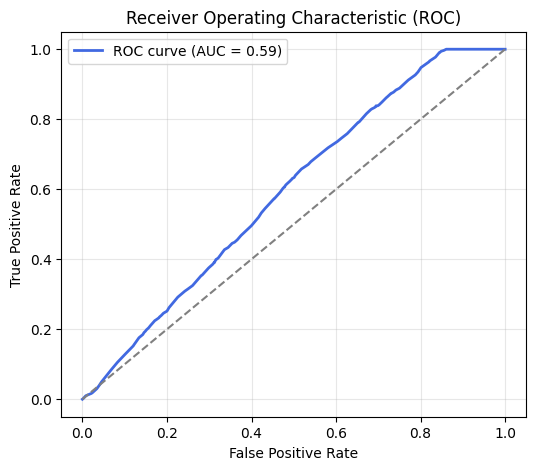

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

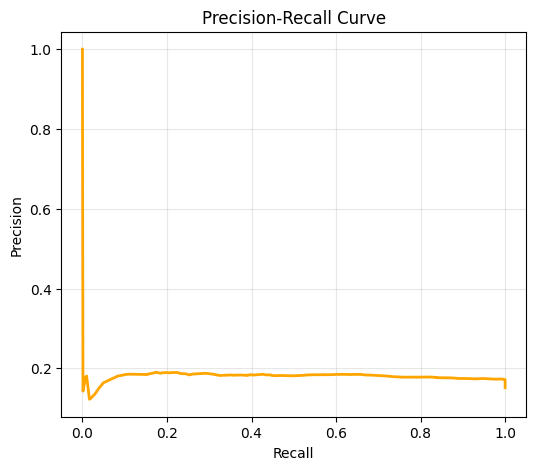

In [33]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='orange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)
plt.show()

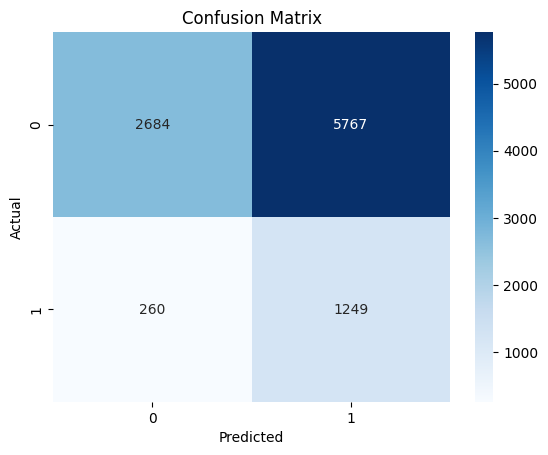

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred > 0.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()